In [1]:
from encode import sample_files, get_dusted_units, get_hubert_units
from utils.features import DataSet
from pathlib import Path
import concurrent.futures

dataset = DataSet(
    name="librispeech-dev-clean",
    in_dir=Path("data/dev-clean"),
    align_dir=Path("data/alignments/dev-clean"),
    feat_dir=Path("features"), 
    audio_ext=".flac" 
)

sampled_paths = sample_files(dataset, 5)
print(len(sampled_paths))

5


In [3]:
from distance import load_units

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_hubert = executor.submit(load_units, dataset, sampled_paths, 0.0)
    future_dusted = executor.submit(load_units, dataset, sampled_paths, 0.2)

    hubert_words = future_hubert.result()
    dusted_words = future_dusted.result()

Loading Units: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


In [20]:

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_hubert = executor.submit(get_hubert_units, dataset, sampled_paths)
    future_dusted = executor.submit(get_dusted_units, dataset, sampled_paths)

    hubert_words = future_hubert.result()
    dusted_words = future_dusted.result()

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting DUSTED units: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


In [4]:
from collections import Counter

num_words = len(hubert_words)
true_words = []

avg_words = []
for w in range(num_words): 
    new_word = hubert_words[w].copy()
    hubert_units = hubert_words[w].clean_encoding
    dusted_units = dusted_words[w].clean_encoding

    common_units = list(dict.fromkeys(unit for unit in hubert_units if unit in dusted_units))
    new_word.update_encoding(common_units)
    avg_words.append(new_word)

    if not isinstance(new_word.true_word, str):
        true_words.append("_")
    else:
        true_words.append(new_word.true_word)

counts = Counter(true_words)
not_ones = {}
for c in counts:
    if counts[c] > 1:
        not_ones[c] = counts[c]
print(not_ones)


{'never': 2, '_': 12, 'it': 3, 'i': 2, 'was': 2, 'any': 2, 'had': 2, 'bright': 2, 'for': 3, 'he': 2, 'and': 3, 'a': 3, 'the': 4, 'of': 2}


In [46]:
import numpy as np 
from tqdm import tqdm
import editdistance

true_words = []
dusted_true_words = []
dist_mat_hub = np.zeros((num_words, num_words))
dist_mat_dust = np.zeros((num_words, num_words))
for i in tqdm(range(num_words), desc="Calculating Distances"):
    true_words.append(hubert_words[i].true_word)
    dusted_true_words.append(dusted_words[i].true_word)
    for j in range(i+1, num_words):
        dist_mat_hub[i, j] = editdistance.eval(hubert_words[i].clean_encoding, hubert_words[j].clean_encoding)
        dist_mat_hub[j, i] = dist_mat_hub[i, j]

        dist_mat_dust[i, j] = editdistance.eval(dusted_words[i].clean_encoding, dusted_words[j].clean_encoding)
        dist_mat_dust[j, i] = dist_mat_dust[i, j]

print(true_words)

Calculating Distances: 100%|██████████| 131/131 [00:00<00:00, 3625.92it/s]

['_', 'not', 'satisfied', 'with', 'gossip', 'in', 'private', 'the', 'greedy', 'public', 'appetite', 'devours', 'gossip', 'in', 'print', '_', 'and', 'wants', 'more', 'of', 'it', 'than', 'any', 'one', 'editor', 'can', 'supply', '_', 'the', 'only', 'true', 'motive', 'for', 'putting', 'poetry', 'into', 'a', 'fresh', 'language', '_', 'must', 'be', 'to', 'endow', 'a', 'fresh', 'nation', 'as', 'far', 'as', 'possible', '_', 'with', 'one', 'more', 'possession', 'of', 'beauty', '_', 'it', 'would', 'have', 'taken', 'many', 'knapsacks', 'to', 'hold', 'all', 'the', 'gifts', 'showered', 'upon', 'him', 'by', 'his', 'friends', 'and', 'neighbors', '_', 'it', 'was', 'almost', 'buried', 'now', 'in', 'flowers', 'and', 'foliage', '_', 'in', 'his', 'own', 'thought', 'he', 'rose', 'superior', 'to', 'them', '_', 'he', 'scorned', 'them', '_', 'even', 'as', 'a', 'lofty', 'spirit', 'absorbed', 'in', 'its', 'stern', 'task', 'rejects', '_', 'the', 'soft', 'beds', '_', 'the', 'luxurious', 'food', '_', 'the', 'pleas

/tmp/ipykernel_77005/799663356.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_mat_dust, method='average')


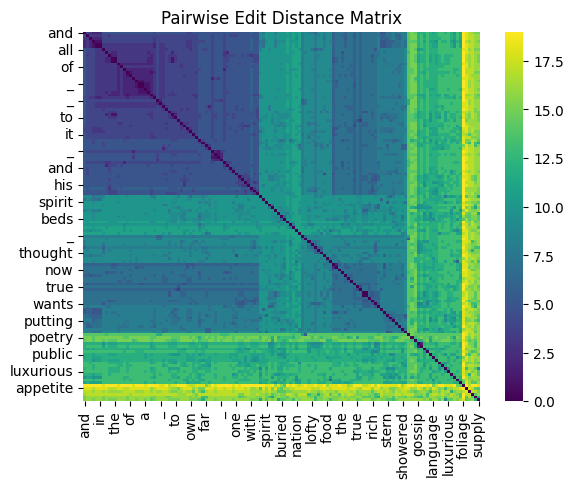

Cluster 5
in
in
in

Cluster 7
the
the
the

Cluster 14
_
_
_

Cluster 35
a
a
of

Cluster 36
fresh
fresh

Cluster 91
_
_
_
a
a



In [49]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df_dust = pd.DataFrame(dist_mat_dust, index=true_words, columns=true_words)
linked = linkage(dist_mat_dust, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_dust.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

dust_clusters = cluster(dist_mat_dust, 2)

for d, d_clust in enumerate(dust_clusters):
    if len(d_clust)>1:
        print(f"Cluster {d}")
        for k in range(len(d_clust)):
            word_k = [w for w in dusted_words if w.id == d_clust[k]]
            print(word_k[0].true_word)
        print()

In [38]:
from cluster import cluster

print(dist_mat_hub[0:5, 0:5])
print()

hub_clusters = cluster(dist_mat_hub, 3)

for h, h_clust in enumerate(hub_clusters):
    if len(h_clust)>1:
        print(f"Cluster {h}")
        for k in range(len(h_clust)):
            word_k = [w for w in dusted_words if w.id == h_clust[k]]
            print(word_k[0].true_word)
        print()

[[ 0. 20. 37. 20. 24.]
 [20.  0. 35. 15. 19.]
 [37. 35.  0. 36. 31.]
 [20. 15. 36.  0. 23.]
 [24. 19. 31. 23.  0.]]

Cluster 5
in
in

Cluster 7
the
the
the
the
a
a
a
of

Cluster 93
_
_
_
a

